## **Install and Setup Library**



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
%matplotlib inline

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## **I. Data preprocessing**


### **0. Preprocessing function define**

**Remove URLs**

In [5]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|http?://\S+')
    return re.sub(url_pattern, '', text)

**Fix Symbol**

In [6]:
dict_symbol = {
  "-_- ": "chán",
  "8-)": "vui",
  ":$": "thường",
  "=(" : "buồn",
  ":(" : "buồn",
  ":+": "giận",
  ":-(": "khóc",
  ":-H": "giận",
  ":3": "vui",
  ":<": "buồn",
  ":>": "vui",
  ":B": "thường",
  ":D": "vui",
  ":L": "mệt",
  ":P": "vui",
  ":Q": "bực",
  ":T": "bực",
  ":Z": "thường",
  ":o": "thường",
  ":V": "thường",
  ":v": "thường",
  ":|": "thường",
  ":~": "lo",
  ";-X": "bực",
  ";D": "vui",
  ";G": "buồn",
  ";O": "thường",
  ";P": "vui",
  "=)": "vui",
  ":)": "vui",
  ";)" : "vui",
  "=.=": "chán",
  "@@": "chán",
  "B-)": "vui",
  "P-(": "khóc",
  "^^": "vui",
  "T_T" : "buồn",
  "T.T" : "buồn",
  ":-O" : "ngờ",
  ":3" : "vui"
}
def fix_symbol(sentence):
    output = ""
    t = sentence.split(" ")
    flagSymbol = 0
    keySymbol = list(dict_symbol.keys())
    for word in t:
        for key in keySymbol:
            if key in word:
                output += dict_symbol[key] + " "
        if flagSymbol == 0:
            output += word + " "

    return output


**Remove Stopword**

In [7]:
stopword = [
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện",
    "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
    "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "một_cách",
    "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra",
    "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng",
    "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"
]

def remove_stopwords(text):
    words = text.split(' ')
    filtered_words = [word for word in words if word.casefold() not in stopword]
    filtered_text = ' '.join(filtered_words)
    return filtered_text


**Remove Multi-space**

In [8]:
def replace_multi_space(text):
  return re.sub(r"\s+", " ", text)

**Text Cleaner**

In [9]:
def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub("[^a-zàáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]", " ", text)
    return text

In [10]:
def text_preprocess(text):
  text = remove_urls(text)
  text = fix_symbol(text)
  text = remove_stopwords(text)
  text = replace_multi_space(text)
  text = text_cleaner(text)
  return text

**Read Data**

In [11]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [12]:
data_train['Data'] = data_train['Data'].apply(text_preprocess)
data_test['Data'] = data_test['Data'].apply(text_preprocess)

### **1. Train data**




In [13]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [14]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [15]:
encoded_labels = []
for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [16]:
reviews_processed = []
unlabeled_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)

In [17]:
#Use PyVi for Vietnamese word tokenizer
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())

In [18]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [19]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [20]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


### **2. Test data**




In [21]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [22]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)

In [23]:
reviews_processed_test = []
unlabeled_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [24]:
print(reviews_processed)

['mình dùng anywhere thế hệ đầu  quả đầy thất vọng  hiện vứt xó  giá đắt  ngốn pin ăn gỏi  nặng ', 'quan tâm nhất độ trễ cao không  dùng thi thoảng nó trễ bực mình  đấy mới dùng văn phòng game chắc ném đi lâu  biết con độ trễ nhỉ  dùng loại kết nhất con chuột sứ mitsumi  gọn bấm nảy tốt ', 'dag xài con cùi bắp   k    pin trâu  tội đánh liên minh ức chế đập hết   con ', 'logitech chắc hàng tiền triệu trở dùng mới thích em dùng con    k thấy vài bữa hư  chuyển sang eblue dùng hơn năm thấy hỏng  ', 'xài con m    cùi mía   nhà xài chuột thử con con kia chơi kết quả   tháng   con chuột khác nhau đủ kiểu đa chức năng h còn con m    cùi mía còn xài dc vui    h đi mua chuột xác định ko mấy con nhân viên vấy ngắn nó dụ nửa logitech fan ', 'xài   con m     nút chuột giữa hai con hạch  xài năm   scroll chạy bậy rồi  hay mua đồ đểu hỉ  ', 'con anywhere   mình dùng double click   lần rồi    chán lắm ', 'hàng cty cấp  cấp xong vứt ở nhà  xài con xornet đỡ mỏi tay  cơ thắc mắc dong thấp nhất  éo bằng

In [25]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [26]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

# **II. Word Embedding**

## **CBOW**

In [27]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Minh/vi-model-CBOW.bin', binary=True)


vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

# **III. Modeling**


## **1. LSTM**

In [28]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Assuming 'data' is your dataset and 'embedding_layer' is pre-defined
sequence_length = data.shape[1]
num_units = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

# LSTM layer with L2 regularization
lstm_layer = LSTM(num_units, return_sequences=False,
                  kernel_regularizer=regularizers.l2(0.01))(embedding)

dropout = Dropout(drop)(lstm_layer)
output = Dense(units=3, activation='softmax',
               kernel_regularizer=regularizers.l2(0.01))(dropout)

# This creates a model that includes
model_LSTM = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_LSTM.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_LSTM.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3224000   
                                                                 
 lstm (LSTM)                 (None, 100)               200400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 3424703 (13.06 MB)
Trainable params: 3424703 (13.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model_LSTM.fit(data, labels, validation_split=0.2,
          epochs=5, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/5
16/16 [==============================] - 13s 227ms/step - loss: 4.4229 - accuracy: 0.4679 - val_loss: 4.3150 - val_accuracy: 0.0196
Epoch 2/5
16/16 [==============================] - 3s 188ms/step - loss: 3.1182 - accuracy: 0.5902 - val_loss: 3.3993 - val_accuracy: 0.0451
Epoch 3/5
16/16 [==============================] - 4s 237ms/step - loss: 2.2366 - accuracy: 0.6588 - val_loss: 2.9075 - val_accuracy: 0.1010
Epoch 4/5
16/16 [==============================] - 3s 181ms/step - loss: 1.6646 - accuracy: 0.7113 - val_loss: 2.8125 - val_accuracy: 0.1284
Epoch 5/5
16/16 [==============================] - 2s 154ms/step - loss: 1.3216 - accuracy: 0.7520 - val_loss: 3.1622 - val_accuracy: 0.0451


## **2. CNN**

In [30]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout,concatenate
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model_CNN = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_CNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_CNN.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

KerasTensor(type_spec=TensorSpec(shape=(None, 297, 100), dtype=tf.float32, name=None), name='conv1d_1/Relu:0', description="created by layer 'conv1d_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 400)             3224000   ['input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 298, 100)             120100    ['embedding[1][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 2

In [31]:
model_CNN.fit(data, labels, validation_split=0.2,
          epochs=5, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/5
16/16 [==============================] - 12s 452ms/step - loss: 7.2383 - accuracy: 0.4654 - val_loss: 6.2140 - val_accuracy: 0.3324
Epoch 2/5
16/16 [==============================] - 3s 178ms/step - loss: 5.4224 - accuracy: 0.6529 - val_loss: 7.5942 - val_accuracy: 0.0461
Epoch 3/5
16/16 [==============================] - 3s 170ms/step - loss: 4.4846 - accuracy: 0.7456 - val_loss: 6.7424 - val_accuracy: 0.0647
Epoch 4/5
16/16 [==============================] - 4s 254ms/step - loss: 3.8505 - accuracy: 0.8167 - val_loss: 5.5175 - val_accuracy: 0.1225
Epoch 5/5
16/16 [==============================] - 3s 166ms/step - loss: 3.3521 - accuracy: 0.8529 - val_loss: 4.7754 - val_accuracy: 0.1863


## **3. CRNN**

In [32]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
# reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

################# SINGLE LSTM ####################
# lstm_0 = LSTM(512)(reshape)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
# lstm_2 = LSTM(1024, return_sequences=True)(reshape)
# lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
# lstm_0 = LSTM(256)(lstm_1)

############################################################


################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPool1D(300)(conv_0)
conv_1 = MaxPool1D(300)(conv_1)
conv_2 = MaxPool1D(300)(conv_2)
# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])
# concat = Flatten()(concat)
lstm_0 = LSTM(256)(concat)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
# lstm_2 = LSTM(1024, return_sequences=True)(concat)
# lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
# lstm_0 = LSTM(256)(lstm_1)

############################################################

dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model_CRNN = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_CRNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_CRNN.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 400)             3224000   ['input_3[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 300, 400)             0         ['embedding[2][0]']           
                                                                                                  
 conv1d_3 (Conv1D)           (None, 300, 100)             120100    ['reshape_1[0][0]']           
                                                                                            

In [33]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

model_CRNN.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/10
16/16 [==============================] - 12s 409ms/step - loss: 4.7534 - accuracy: 0.4946 - val_loss: 4.4026 - val_accuracy: 0.0000e+00
Epoch 2/10
16/16 [==============================] - 4s 240ms/step - loss: 2.6174 - accuracy: 0.6529 - val_loss: 2.9752 - val_accuracy: 0.0000e+00
Epoch 3/10
16/16 [==============================] - 3s 198ms/step - loss: 1.5455 - accuracy: 0.7333 - val_loss: 2.3808 - val_accuracy: 0.0500
Epoch 4/10
16/16 [==============================] - 3s 156ms/step - loss: 1.0299 - accuracy: 0.8333 - val_loss: 2.2795 - val_accuracy: 0.1216
Epoch 5/10
16/16 [==============================] - 2s 154ms/step - loss: 0.7233 - accuracy: 0.9196 - val_loss: 2.6799 - val_accuracy: 0.0912
Epoch 6/10
16/16 [==============================] - 5s 273ms/step - loss: 0.5471 - accuracy: 0.9635 - val_loss: 2.2490 - val_accuracy: 0.2441
Epoch 7/10
16/16 [==============================] - 3s 198ms/step - loss: 0.4599 - accuracy: 0.9718 - val_loss: 2.4214 - val_accuracy: 0.24

## **4. GRU**

In [34]:
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Assuming the embedding_layer is predefined
sequence_length = data.shape[1]  # Length of input sequences
drop = 0.5

# Input and embedding layer
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

# GRU Layer
gru_layer = GRU(100, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(embedding)  # 100 units in GRU layer

# Dropout layer
dropout = Dropout(drop)(gru_layer)

# Output layer
output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

# Creating a model
model_GRU = Model(inputs, output)

# Optimizer
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_GRU.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Model summary
model_GRU.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3224000   
                                                                 
 gru (GRU)                   (None, 100)               150600    
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 303       
                                                                 
Total params: 3374903 (12.87 MB)
Trainable params: 3374903 (12.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model_GRU.fit(data, labels, validation_split=0.2,
          epochs=5, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/5
16/16 [==============================] - 5s 169ms/step - loss: 4.1464 - accuracy: 0.4694 - val_loss: 4.1728 - val_accuracy: 0.1382
Epoch 2/5
16/16 [==============================] - 3s 161ms/step - loss: 3.0897 - accuracy: 0.6025 - val_loss: 3.6264 - val_accuracy: 0.0863
Epoch 3/5
16/16 [==============================] - 3s 186ms/step - loss: 2.3567 - accuracy: 0.6895 - val_loss: 3.2758 - val_accuracy: 0.0676
Epoch 4/5
16/16 [==============================] - 2s 148ms/step - loss: 1.8145 - accuracy: 0.7623 - val_loss: 2.8520 - val_accuracy: 0.1176
Epoch 5/5
16/16 [==============================] - 2s 120ms/step - loss: 1.5036 - accuracy: 0.7826 - val_loss: 2.8258 - val_accuracy: 0.1167


# **Testing**

### **Lost & Accuracy**

In [36]:
score = model_LSTM.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_LSTM.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], score[1]*100))

33/33 [==============================] - 0s 12ms/step - loss: 1.6742 - accuracy: 0.5971
loss: 167.42%
accuracy: 59.71%


In [37]:
score = model_CNN.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_LSTM.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], score[1]*100))

33/33 [==============================] - 1s 12ms/step - loss: 3.7445 - accuracy: 0.6229
loss: 374.45%
accuracy: 62.29%


In [38]:
score = model_CRNN.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_LSTM.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], score[1]*100))

33/33 [==============================] - 1s 11ms/step - loss: 1.4496 - accuracy: 0.6248
loss: 144.96%
accuracy: 62.48%


In [39]:
score = model_GRU.evaluate(data_test, labels_test)
print("%s: %.2f%%" % (model_LSTM.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], score[1]*100))

33/33 [==============================] - 0s 6ms/step - loss: 1.8480 - accuracy: 0.5962
loss: 184.80%
accuracy: 59.62%


### **Accuray + Precise + Recall + F1**

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(X_test_scaled, Y_test, model=None):
    y_predict_r = model.predict(X_test_scaled)
    labels = []
    for row in y_predict_r:
      max_index = np.argmax(row)
      label = [0] * len(row)
      label[max_index] = 1
      labels.append(label)
    acc = accuracy_score(Y_test, labels)
    prec = precision_score(Y_test, labels, average='macro')
    rec = recall_score(Y_test, labels, average='macro')
    f1 = f1_score(Y_test, labels, average='macro')

    return acc, prec, rec, f1

def get_metrics(X_test, Y_test, model=None):
    acc, prec, rec, f1 = calculate_metrics(X_test, Y_test, model=model)

    display_df = pd.DataFrame([[acc, prec, rec, f1]], columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return display_df


**Summary & Visualization**

In [48]:
modelist = [model_LSTM, model_CNN, model_CRNN, model_GRU]
data = [calculate_metrics(data_test, labels_test, model)  for model in modelist]
df = pd.DataFrame(data, columns=["Accuracy", "Precision", "Recall", "F1 Score"])
df["Model"] = ["LSTM", "CNN", "CRNN", "GRU"]
df

33/33 [==============================] - 0s 5ms/step


,Accuracy,Precision,Recall,F1 Score,Model
0,0.597143,0.676844,0.597143,0.542710,LSTM
1,0.622857,0.641010,0.622857,0.605279,CNN
2,0.624762,0.642576,0.624762,0.608349,CRNN
3,0.596190,0.638519,0.596190,0.561274,GRU


In [49]:
print(df)

   Accuracy  Precision    Recall  F1 Score Model
0  0.597143   0.676844  0.597143  0.542710  LSTM
1  0.622857   0.641010  0.622857  0.605279   CNN
2  0.624762   0.642576  0.624762  0.608349  CRNN
3  0.596190   0.638519  0.596190  0.561274   GRU


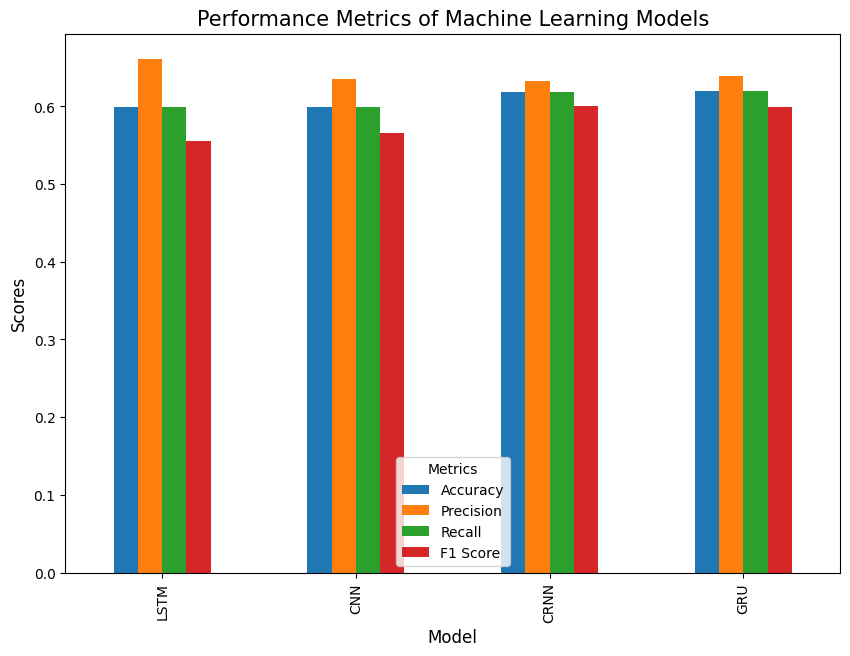

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe
data = {
    'Accuracy': [0.599048, 0.599048, 0.619048, 0.620000],
    'Precision': [0.660619, 0.635382, 0.632591, 0.639313],
    'Recall': [0.599048, 0.599048, 0.619048, 0.620000],
    'F1 Score': [0.554997, 0.565326, 0.600286, 0.598782],
    'Model': ['LSTM', 'CNN', 'CRNN', 'GRU']
}
df = pd.DataFrame(data)

# Set the index to 'Model'
df.set_index('Model', inplace=True)

# Plot a grouped bar chart
ax = df.plot(kind='bar', figsize=(10, 7))

# Set plot title and labels
ax.set_title('Performance Metrics of Machine Learning Models', fontsize=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)

# Show the legend
ax.legend(title='Metrics')

# Show the plot
plt.show()


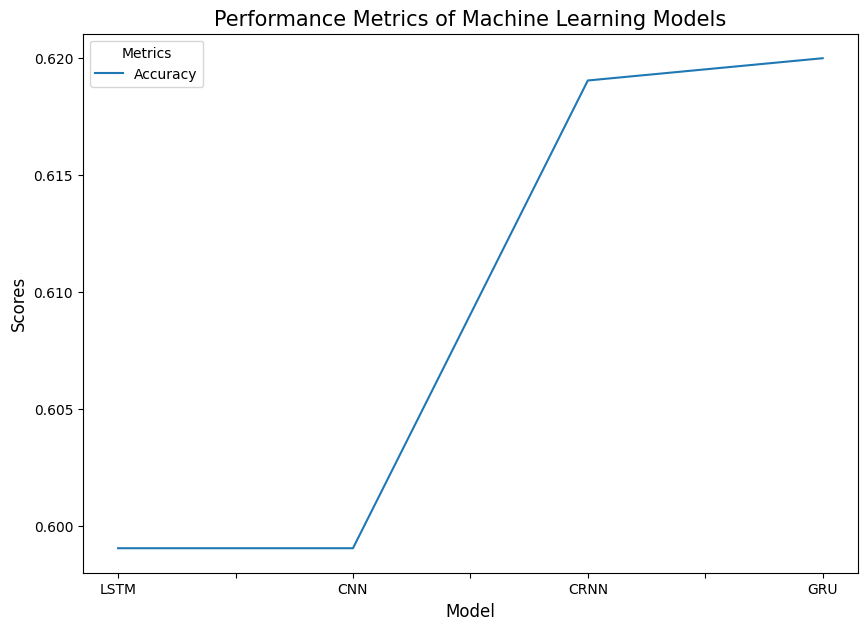

In [51]:
data = {
    'Accuracy': [0.599048, 0.599048, 0.619048, 0.620000],
    'Model': ['LSTM', 'CNN', 'CRNN', 'GRU']
}
df = pd.DataFrame(data)

# Set the index to 'Model'
df.set_index('Model', inplace=True)

# Plot a grouped bar chart
ax = df.plot(kind='line', figsize=(10, 7))

# Set plot title and labels
ax.set_title('Performance Metrics of Machine Learning Models', fontsize=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)

# Show the legend
ax.legend(title='Metrics')

# Show the plot
plt.show()

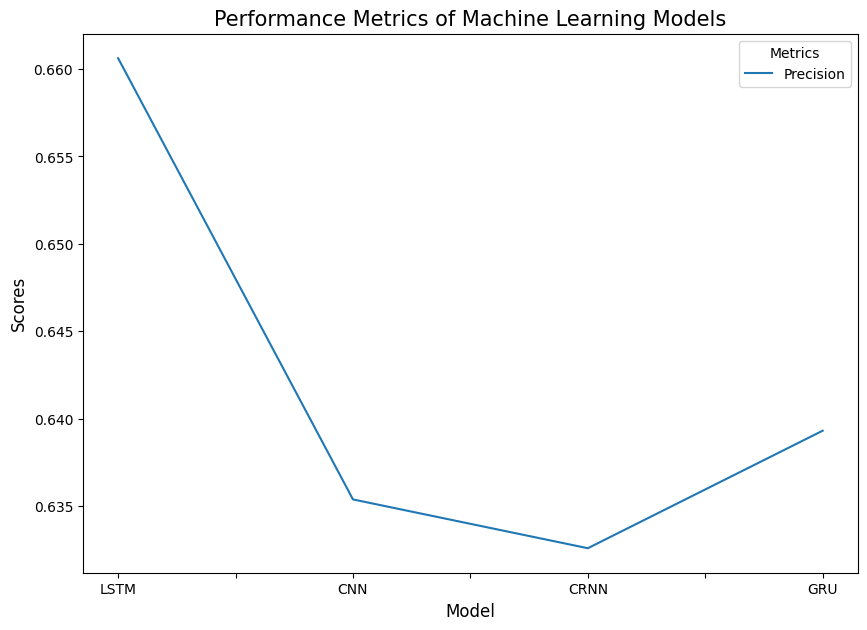

In [52]:

data = {
    'Precision': [0.660619, 0.635382, 0.632591, 0.639313],
    'Model': ['LSTM', 'CNN', 'CRNN', 'GRU']
}
df = pd.DataFrame(data)

# Set the index to 'Model'
df.set_index('Model', inplace=True)

# Plot a grouped bar chart
ax = df.plot(kind='line', figsize=(10, 7))

# Set plot title and labels
ax.set_title('Performance Metrics of Machine Learning Models', fontsize=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)

# Show the legend
ax.legend(title='Metrics')

# Show the plot
plt.show()


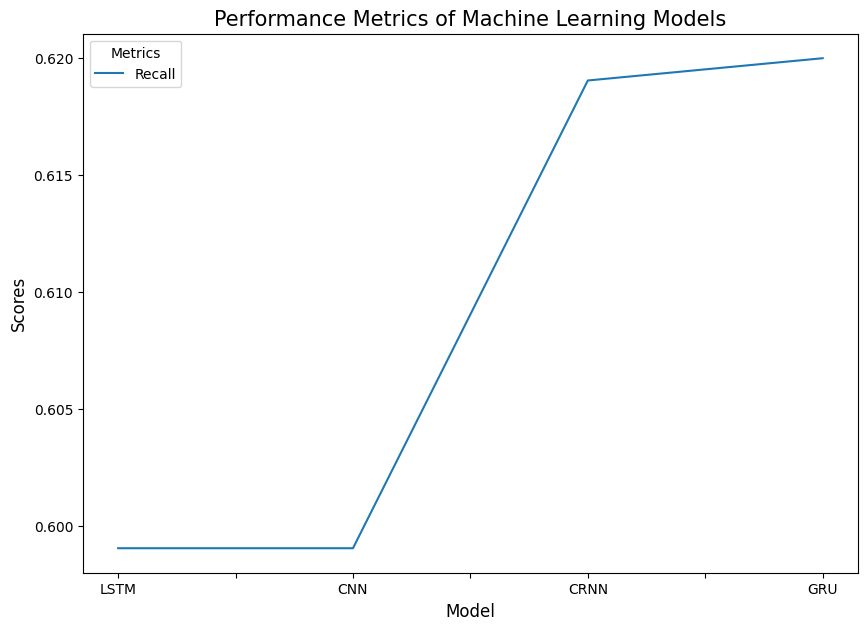

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe
data = {
    'Recall': [0.599048, 0.599048, 0.619048, 0.620000],
    'Model': ['LSTM', 'CNN', 'CRNN', 'GRU']
}
df = pd.DataFrame(data)

# Set the index to 'Model'
df.set_index('Model', inplace=True)

# Plot a grouped bar chart
ax = df.plot(kind='line', figsize=(10, 7))

# Set plot title and labels
ax.set_title('Performance Metrics of Machine Learning Models', fontsize=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)

# Show the legend
ax.legend(title='Metrics')

# Show the plot
plt.show()


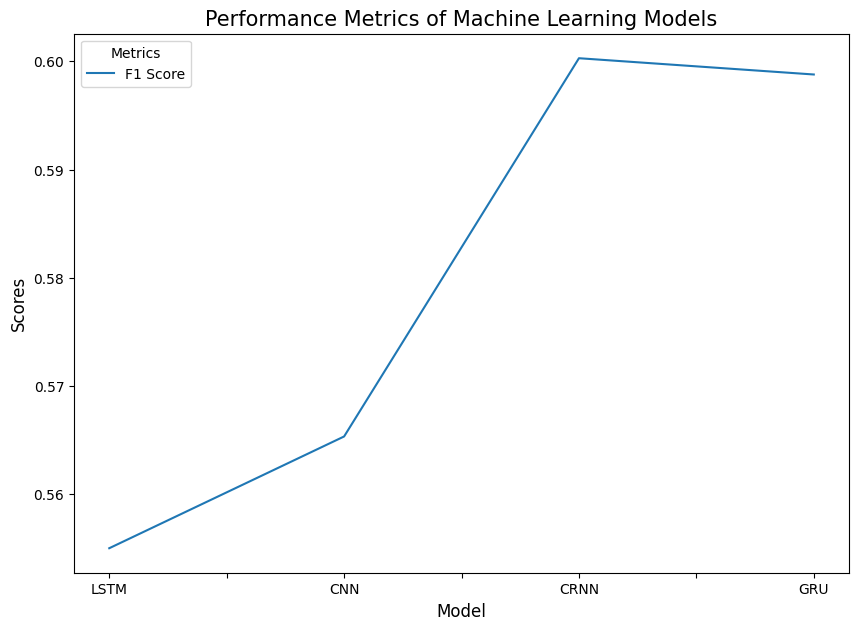

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe
data = {
    'F1 Score': [0.554997, 0.565326, 0.600286, 0.598782],
    'Model': ['LSTM', 'CNN', 'CRNN', 'GRU']
}
df = pd.DataFrame(data)

# Set the index to 'Model'
df.set_index('Model', inplace=True)

# Plot a grouped bar chart
ax = df.plot(kind='line', figsize=(10, 7))

# Set plot title and labels
ax.set_title('Performance Metrics of Machine Learning Models', fontsize=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)

# Show the legend
ax.legend(title='Metrics')

# Show the plot
plt.show()
